In [1]:
import matplotlib.pyplot as plt
import os
import missingno as msno
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Merging two datasets


In [2]:
import json

js15 = json.load(open('dataset/socrata_metadata_2015-building-energy-benchmarking.json', mode='r'))
js16 = json.load(open('dataset/socrata_metadata_2016-building-energy-benchmarking.json', mode='r'))

In [3]:
df15 = pd.read_csv('dataset/2015-building-energy-benchmarking.csv')
df16 = pd.read_csv('dataset/2016-building-energy-benchmarking.csv')

In [4]:
print(df15.shape)
print(df15.columns)

(3340, 47)
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'Defa

In [5]:
print(df16.shape)
print(df16.columns)

(3376, 46)
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
    

In [6]:
# montrer les differences de colonnes entre les dataset

contained16in15 = [col in df16.columns for col in df15.columns ]
extra15 = df15.columns[np.invert(contained16in15)]
print(extra15)

# describe to what corresponds the extra columns
for col in extra15:
	print(col, ' : ', next(item for item in js15['columns'] if item['name'] == col).get('description'))


Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')
Location  :  None
OtherFuelUse(kBtu)  :  None
GHGEmissions(MetricTonsCO2e)  :  The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. 
GHGEmissionsIntensity(kgCO2e/ft2)  :  	
Total Greenhouse Gas Emissions divided by 

In [7]:
contained15in16 = [col in df15.columns for col in df16.columns ]
extra16 = df16.columns[np.invert(contained15in16)]
print(extra16)

# describe to what corresponds the extra columns
for col in extra16:
	print(col, ' : ', next(item for item in js16['columns'] if item['name'] == col).get('description'))


Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')
Address  :  Property street address
City  :  Property city
State  :  Property state
ZipCode  :  Property zip
Latitude  :  Property latitude.
Longitude  :  Property longitude.
Comments  :  Comments by a building owner or agent to provide context to the building’s energy use.  
TotalGHGEmissions  :  The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Man

In [8]:
# examples of Location
print(df15.loc[0, 'Location'])
print(df16.loc[0, ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']])
# df15 has location in one single row
# whereas df1516 has one column for each data
# let's split !


{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}
Address      405 Olive way
City               Seattle
State                   WA
ZipCode            98101.0
Latitude           47.6122
Longitude       -122.33799
Name: 0, dtype: object


In [9]:
import ast
		
# split Location column
for index, row in df15.iterrows():
	l = ast.literal_eval(df15.loc[index, 'Location'])
	addr = ast.literal_eval(l['human_address'])
	df15.loc[index, 'Latitude'] = l['latitude']
	df15.loc[index, 'Longitude'] = l['longitude']
	df15.loc[index, 'Address'] = addr['address']
	df15.loc[index, 'City'] = addr['city']
	df15.loc[index, 'State'] = addr['state']
	df15.loc[index, 'ZipCode'] = addr['zip']


# convert to correct type as ast convert to str
df15=df15.astype({'Latitude' : 'float64', 'Longitude' : 'float64', 'ZipCode' : 'float64'})


In [10]:
print(df16['TotalGHGEmissions'].describe())
print(df15['GHGEmissions(MetricTonsCO2e)'].describe())

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64
count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64


In [11]:
print(df16['GHGEmissionsIntensity'].describe())
print(df15['GHGEmissionsIntensity(kgCO2e/ft2)'].describe())

count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64
count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64


In [12]:

# columns from df15 and df16 are on the same scale, so they can be merged as is in the resulting dataset
# copy identical columns then will drop all
df15['TotalGHGEmissions'] = df15['GHGEmissions(MetricTonsCO2e)']
df15['GHGEmissionsIntensity'] = df15['GHGEmissionsIntensity(kgCO2e/ft2)']

df15.drop(extra15, axis=1, inplace=True)
df16.drop('Comments', axis=1, inplace=True)


In [13]:
# merge common columns
df = pd.merge(df15, df16, how='outer')
dfbak = df.copy()
print(df15.shape, df16.shape, df.shape)



(3340, 45) (3376, 45) (6716, 45)


# Exploratory Data Analysis

In [14]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,...,Compliant,NaN,47.612190,-122.337997,405 OLIVE WAY,SEATTLE,WA,98101.0,249.43,2.64
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,...,Compliant,NaN,47.613106,-122.333358,724 PINE ST,SEATTLE,WA,98101.0,263.51,2.38
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,...,Compliant,NaN,47.613349,-122.337699,1900 5TH AVE,SEATTLE,WA,98101.0,2061.48,1.92
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,...,Compliant,High Outlier,47.614216,-122.336609,620 STEWART ST,SEATTLE,WA,98101.0,1936.34,31.38
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,...,Compliant,NaN,47.613754,-122.340924,401 LENORA ST,SEATTLE,WA,98121.0,507.70,4.02


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

## Location of Buildings

In [16]:
# Just for fun, display the points on a map
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df.loc[0, 'Latitude'], df.loc[0, 'Longitude']], zoom_start=13)
marker_cluster = MarkerCluster().add_to(m)

for index, row in df.iterrows():
	folium.Marker([row['Latitude'], row['Longitude']]).add_to(marker_cluster)

m

## Data Cleaning

<AxesSubplot:ylabel='None'>

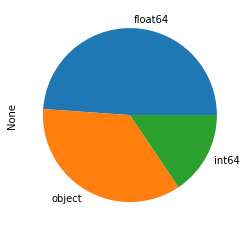

In [17]:
df.dtypes.value_counts().plot.pie()

### Empty Features analysis

<AxesSubplot:>

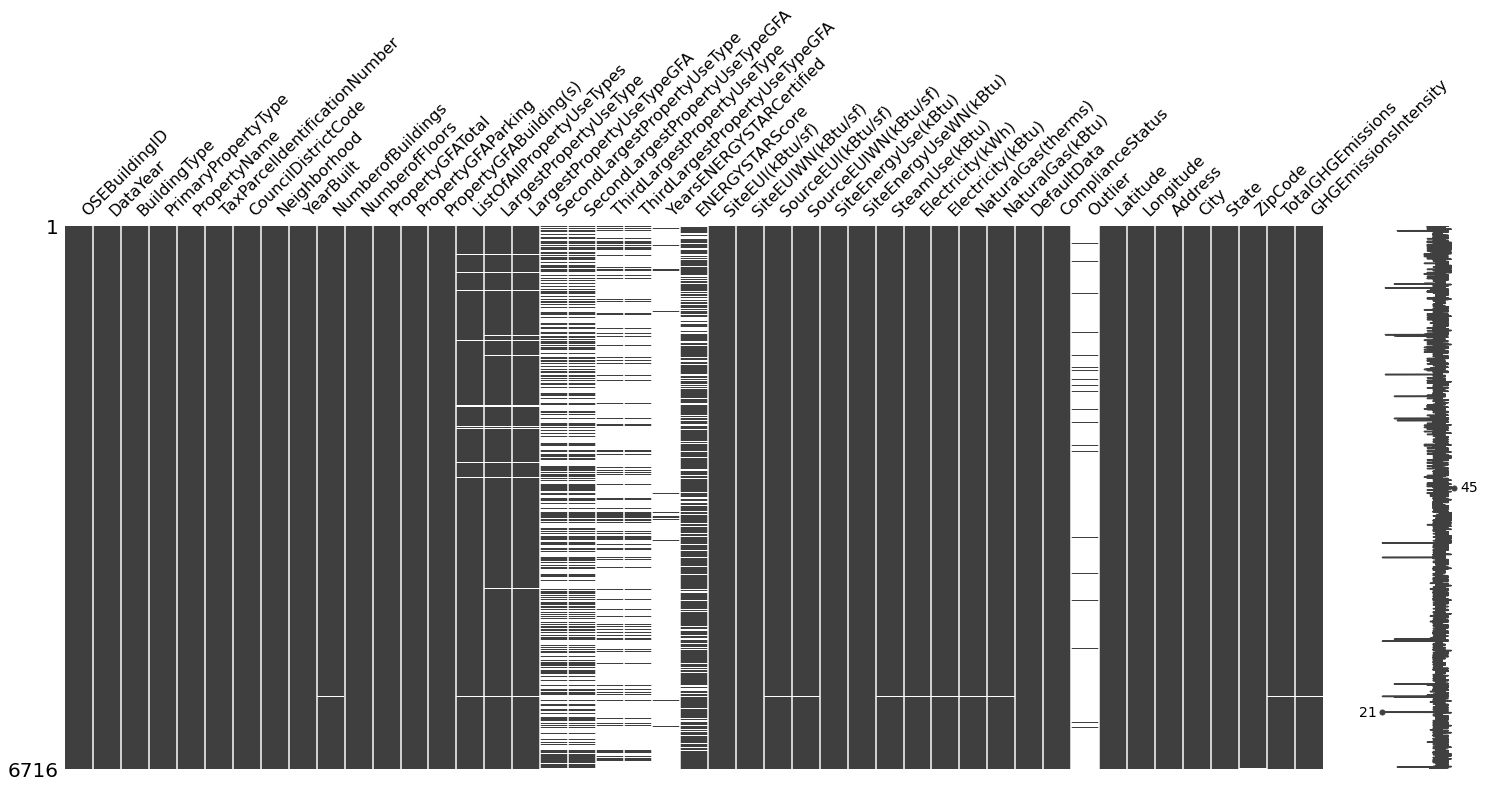

In [18]:
import missingno as msno
msno.matrix(df)

<AxesSubplot:ylabel='Frequency'>

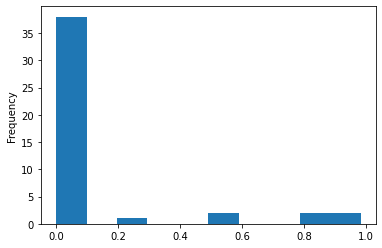

In [19]:
# show columns with (too much) empty values
df.isna().mean().sort_values().plot(kind="hist")

In [20]:
# removing columns that have more than 50% of empty values
threshold = 0.5
for col in df.columns:
	if df[col].isna().mean() > threshold:
		print('removing empty column: ', col)
		df.drop(col, axis=1, inplace=True)


removing empty column:  SecondLargestPropertyUseType
removing empty column:  SecondLargestPropertyUseTypeGFA
removing empty column:  ThirdLargestPropertyUseType
removing empty column:  ThirdLargestPropertyUseTypeGFA
removing empty column:  YearsENERGYSTARCertified
removing empty column:  Outlier


### Outliers Analysis

In [21]:
def dropOutlierIQR(df, col):
    Q1 = df[col].quantile(0.25)
    # print(Q1)
    Q3 = df[col].quantile(0.75)
    # print(Q3)
    IQR = Q3 - Q1
    # print(IQR)
    df[col] = df[col][df[col].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR))]

In [22]:
for col in df.select_dtypes(include=['float', 'int']).columns:
	dropOutlierIQR(df, col)

### Non sense Values

In [23]:
df.select_dtypes(exclude='object').lt(0).sum()

OSEBuildingID                   0
DataYear                        0
CouncilDistrictCode             0
YearBuilt                       0
NumberofBuildings               0
NumberofFloors                  0
PropertyGFATotal                0
PropertyGFAParking              0
PropertyGFABuilding(s)          2
LargestPropertyUseTypeGFA       0
ENERGYSTARScore                 0
SiteEUI(kBtu/sf)                0
SiteEUIWN(kBtu/sf)              0
SourceEUI(kBtu/sf)              1
SourceEUIWN(kBtu/sf)            2
SiteEnergyUse(kBtu)             0
SiteEnergyUseWN(kBtu)           0
SteamUse(kBtu)                  0
Electricity(kWh)                1
Electricity(kBtu)               1
NaturalGas(therms)              0
NaturalGas(kBtu)                0
Latitude                        0
Longitude                    6522
ZipCode                         0
TotalGHGEmissions               1
GHGEmissionsIntensity           1
dtype: int64

In [24]:
# remove rows for features that shouldn't be negative
nonNegativeFeatures = ['PropertyGFABuilding(s)',
'SourceEUI(kBtu/sf)',
'SourceEUIWN(kBtu/sf)',
'Electricity(kWh)',
'Electricity(kBtu)',
'TotalGHGEmissions',
'GHGEmissionsIntensity']

for col in nonNegativeFeatures:
	df.drop(df.loc[df[col] < 0].index, inplace=True)

df.shape

(6712, 39)

In [25]:
df.select_dtypes(exclude='object').eq(0).sum()

OSEBuildingID                   0
DataYear                        0
CouncilDistrictCode             0
YearBuilt                       0
NumberofBuildings               0
NumberofFloors                 21
PropertyGFATotal                0
PropertyGFAParking           5286
PropertyGFABuilding(s)          0
LargestPropertyUseTypeGFA       0
ENERGYSTARScore                 0
SiteEUI(kBtu/sf)               18
SiteEUIWN(kBtu/sf)             41
SourceEUI(kBtu/sf)             26
SourceEUIWN(kBtu/sf)           48
SiteEnergyUse(kBtu)            20
SiteEnergyUseWN(kBtu)          41
SteamUse(kBtu)               6433
Electricity(kWh)               16
Electricity(kBtu)              16
NaturalGas(therms)           2510
NaturalGas(kBtu)             2510
Latitude                        0
Longitude                       0
ZipCode                         0
TotalGHGEmissions              11
GHGEmissionsIntensity          20
dtype: int64

In [26]:
# remove rows for features that shouldn't be equal to zero
strictPositiveFeatures = ['NumberofFloors',
'SourceEUI(kBtu/sf)',
'SourceEUIWN(kBtu/sf)',
'SourceEUI(kBtu/sf)',
'SourceEUIWN(kBtu/sf)',
'SiteEnergyUse(kBtu)',
'SiteEnergyUseWN(kBtu)',
'Electricity(kWh)',
'Electricity(kBtu)',
'TotalGHGEmissions',
'GHGEmissionsIntensity']

for col in strictPositiveFeatures:
	df.drop(df.loc[df[col] == 0].index, inplace=True)

df.shape

(6634, 39)

In [27]:
# Remove rows where default data has been set
df.drop(df.loc[df['DefaultData'] == True].index, inplace=True)

## Feature Engineering

### Building Age

In [28]:
# feature engineering : we create an age od the building, more convenient than year of build
df['BuildingAge'] = df.DataYear - df.YearBuilt

### Location

In [29]:
from geopy.distance import distance

df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# official position of Seattle (https://www.latlong.net/place/seattle-wa-usa-2655.html)
d0 = (47.608013, -122.335167)
points = zip(df.Latitude, df.Longitude)
# for p in points:
# 	print(p)
df['Distance'] = [distance(d0, point).miles for point in zip(df.Latitude, df.Longitude)]


### Energy Ratios

In [30]:
#  TODO enlever les relevés de consommation

# we don't want to rely on the consumption data, because this is costly to get. Our model must do without it
#  but we can keep the proportion of each one, to know for example what is the main energy source of a building

# df['ElectricityRate'] = df['Electricity(kBtu)'] / (df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']+1)
# df['NaturalGasRate'] = df['NaturalGas(kBtu)'] / (df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']+1)
# df.drop(['Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1, inplace=True)

## Features Cleanup

In [31]:
# don't need this feature, since duplicates the one with kBtu
df.drop('Electricity(kWh)', axis=1, inplace=True)

# also, we don't need the features 'WN', they are highly correlated with their siblings 'without WN'
colsWN = []
for col in df.columns:
	if 'WN' in col:
		colsWN.append(col)
df.drop(colsWN, axis=1, inplace=True)

# lastly, we can remove NaturalGas(therms), since it the same than naturalGas(kBtu), only the unit change
df.drop('NaturalGas(therms)', axis=1, inplace=True)

# State has unique value
df.drop('State', axis=1, inplace=True)

# except BuildingAge, none of the other features are very interesting, we could drop them
df.drop(['YearBuilt', 'CouncilDistrictCode', 'DataYear'], axis=1, inplace=True)

# some features are not interesting, we could drop them
df.drop(['ZipCode', 'OSEBuildingID', 'SteamUse(kBtu)', 'PropertyGFAParking', 'NumberofBuildings', 'TaxParcelIdentificationNumber'], axis=1, inplace=True)

# remove Default Data feature
df.drop('DefaultData', axis=1, inplace=True)


# Some features are not interesting, we can remove them
df.drop(['PropertyName', 'Address', 'City'], axis=1, inplace=True)

In [32]:
print(df.ListOfAllPropertyUseTypes.describe())
df.ListOfAllPropertyUseTypes.head()
# this feature is a concatenation of several values, seperated by ', '
# we could try to seperate them, but in fact this feature is not very intersting, since there is feature 'LargestPropertyUseType', that we'll use instead

df.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)


count                    6190
unique                    477
top       Multifamily Housing
freq                     1616
Name: ListOfAllPropertyUseTypes, dtype: object


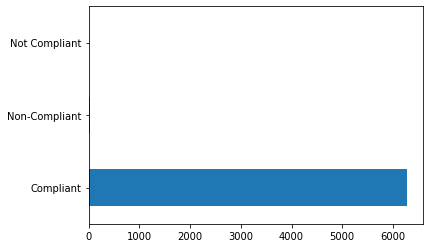

In [33]:
df.ComplianceStatus.value_counts().plot.barh()
# most of the values are compliant, we could remove the ones which are not (they may be misleading our predictions since the energy consumption is not accurate)
df = df[df.ComplianceStatus == 'Compliant']
df.drop(['ComplianceStatus'], axis=1, inplace=True)

### Remove NaN

In [34]:
# TODO WIP
# df.dropna(subset=df.select_dtypes('float').columns.values, inplace=True)

for col in df.columns:
	print(col, df[col].isna().sum())

values = {
	'NumberofFloors' : 0,
	'SiteEUI(kBtu/sf)' : 0
}
df.fillna(value=values)

# drop nan after
nadrop = ['SiteEUI(kBtu/sf)' ]

# df.dropna(subset=[n for n in df if n != 'ENERGYSTARScore'], inplace=True)

# df.loc[:, df.columns != 'ENERGYSTARScore']
# df.dropna(subset=)
# print(df.shape)

BuildingType 0
PrimaryPropertyType 0
Neighborhood 0
NumberofFloors 465
PropertyGFATotal 695
PropertyGFABuilding(s) 645
LargestPropertyUseType 141
LargestPropertyUseTypeGFA 796
ENERGYSTARScore 1530
SiteEUI(kBtu/sf) 496
SourceEUI(kBtu/sf) 583
SiteEnergyUse(kBtu) 735
Electricity(kBtu) 753
NaturalGas(kBtu) 642
Latitude 0
Longitude 0
TotalGHGEmissions 685
GHGEmissionsIntensity 525
BuildingAge 0
Distance 0


In [35]:
# remove some NaN values,
df.dropna(subset=['TotalGHGEmissions'], inplace=True)
df.shape

(4423, 20)

In [36]:
# TODO WIP
# replace NaN values for some features
# example for NumberofFloors --> 0 by default. we consider a building has at least one floor (groundfloor UK ), it's a value that exists and thus is valid
df['NumberofFloors'] = df['NumberofFloors'].fillna(0)

# df['SiteEUI(kBtu/sf)'] = df['SiteEUI(kBtu/sf)'].fillna(0)
# df['SourceEUI(kBtu/sf)'] = df['SourceEUI(kBtu/sf)'].fillna(0)
# df['SiteEnergyUse(kBtu)'] = df['SiteEnergyUse(kBtu)'].fillna(0)


In [37]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'Latitude', 'Longitude', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'BuildingAge', 'Distance'],
      dtype='object')

In [38]:
df.shape

(4423, 20)

In [39]:
dfbak = df.copy()
df.to_pickle("./tmp/df_cleaned.gzip")

## Features Analysis


### Features Correlations Analysis

In [40]:
# features correlations
def show_feat_correlations(df):
	correlations = np.abs(df.select_dtypes('float').corr(method="pearson"))

	mask = np.zeros_like(correlations)
	mask[np.triu_indices_from(mask)] = True
	sns.axes_style("white")
	plt.subplots(figsize=(15,15))
	sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')

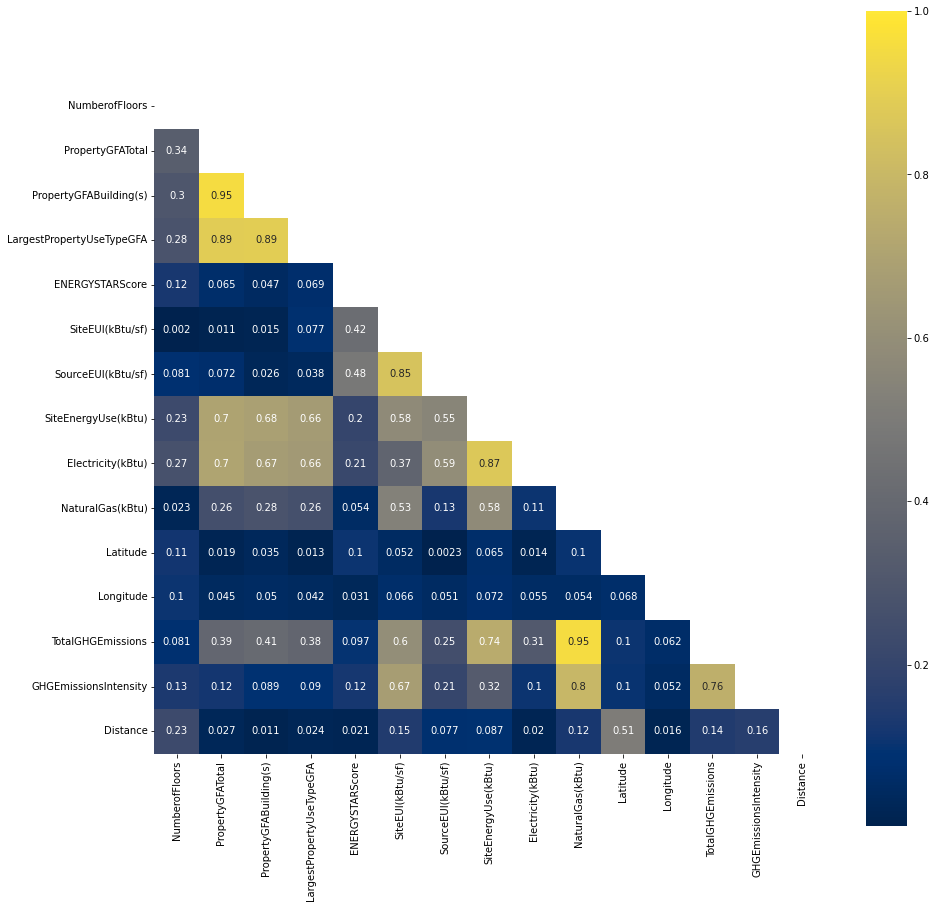

In [41]:
show_feat_correlations(df)

In [42]:
# some features are higly correlated (>0.7), thus we should remove them, otherwise for our further models, we will have data leakage.
# 'PropertyGFABuilding(s)' : can be overcomed by 'PropertyGFATotal'



### Objects type features

In [43]:
df.select_dtypes('object').nunique()

BuildingType               7
PrimaryPropertyType       27
Neighborhood              19
LargestPropertyUseType    47
dtype: int64

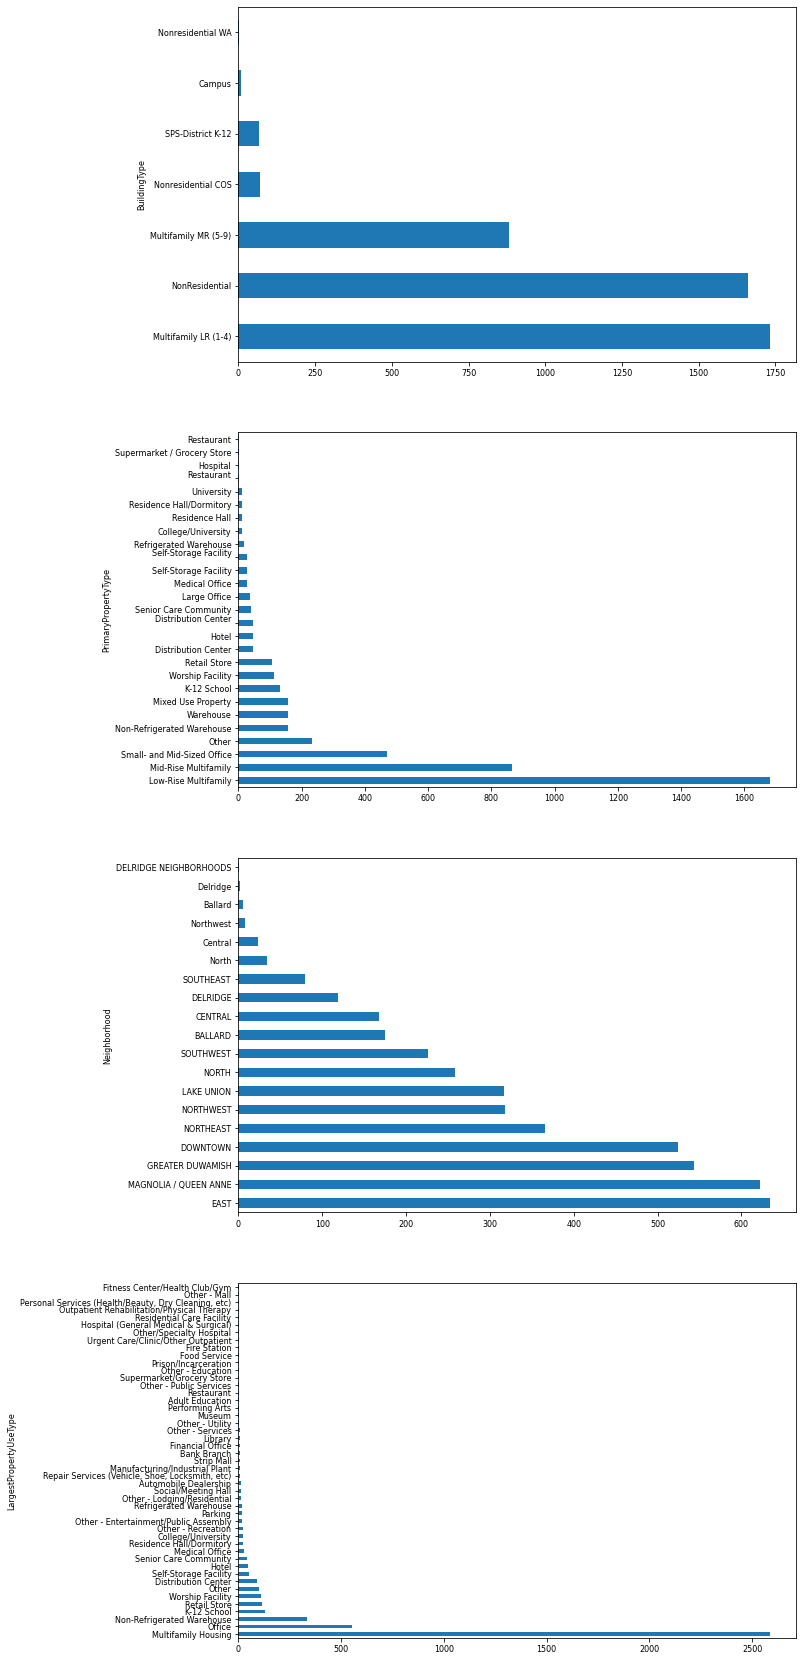

In [44]:
plt.rcParams.update({'font.size': 8})

feats = df.select_dtypes('object').columns

nrows = int(feats.shape[0])
ncols = 1

fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(10,30))

for i, col in enumerate(feats):
	# print(col)
	# print(df[col].describe())
	df[col].value_counts().plot(kind='barh', ax=ax[i], xlabel=col)


### Floats


array([[<AxesSubplot:title={'center':'NumberofFloors'}>,
        <AxesSubplot:title={'center':'PropertyGFATotal'}>,
        <AxesSubplot:title={'center':'PropertyGFABuilding(s)'}>,
        <AxesSubplot:title={'center':'LargestPropertyUseTypeGFA'}>],
       [<AxesSubplot:title={'center':'ENERGYSTARScore'}>,
        <AxesSubplot:title={'center':'SiteEUI(kBtu/sf)'}>,
        <AxesSubplot:title={'center':'SourceEUI(kBtu/sf)'}>,
        <AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}>],
       [<AxesSubplot:title={'center':'Electricity(kBtu)'}>,
        <AxesSubplot:title={'center':'NaturalGas(kBtu)'}>,
        <AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'TotalGHGEmissions'}>,
        <AxesSubplot:title={'center':'GHGEmissionsIntensity'}>,
        <AxesSubplot:title={'center':'BuildingAge'}>,
        <AxesSubplot:title={'center':'Distance'}>]], dtype=object)

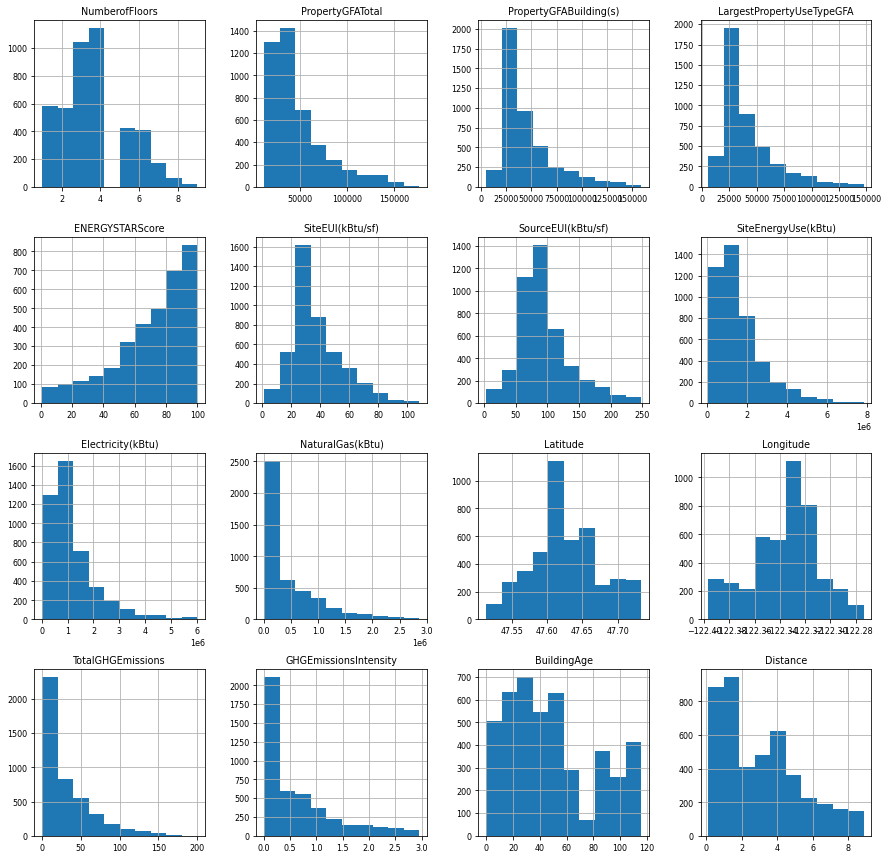

In [45]:
df.hist(figsize=(15,15))

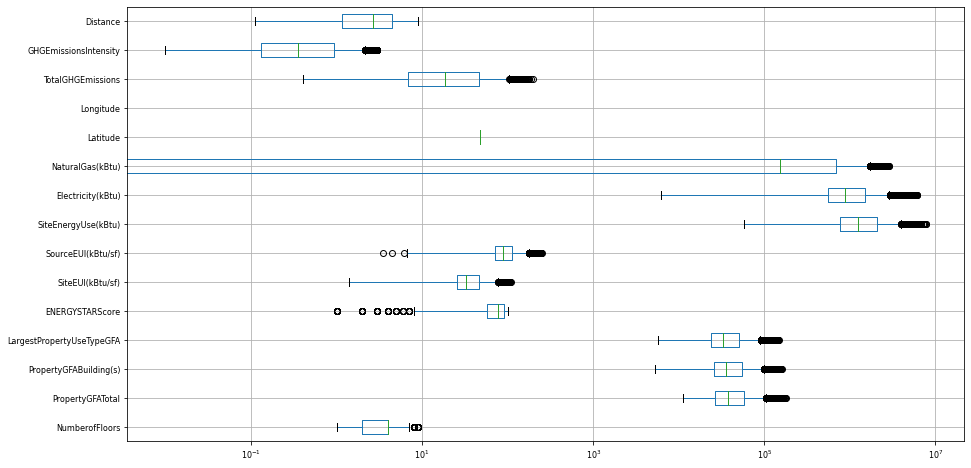

In [46]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15,8))
df.select_dtypes('float').boxplot(vert=False)
plt.xscale('log')


### Univariate Analysis

<AxesSubplot:xlabel='GHGEmissionsIntensity', ylabel='Density'>

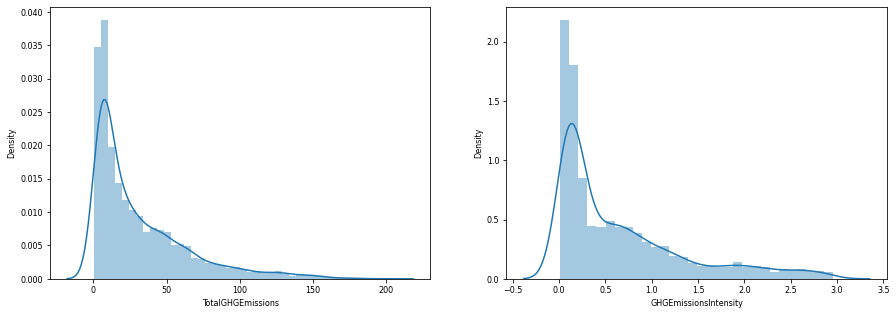

In [47]:
# TotalGHGEmissions & GHGEmissionsIntensity specific analysis

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,5))
sns.distplot(df.TotalGHGEmissions, ax=ax[0])
sns.distplot(df.GHGEmissionsIntensity, ax=ax[1])

## Multivariate Analysis

<AxesSubplot:xlabel='NaturalGas(kBtu)', ylabel='TotalGHGEmissions'>

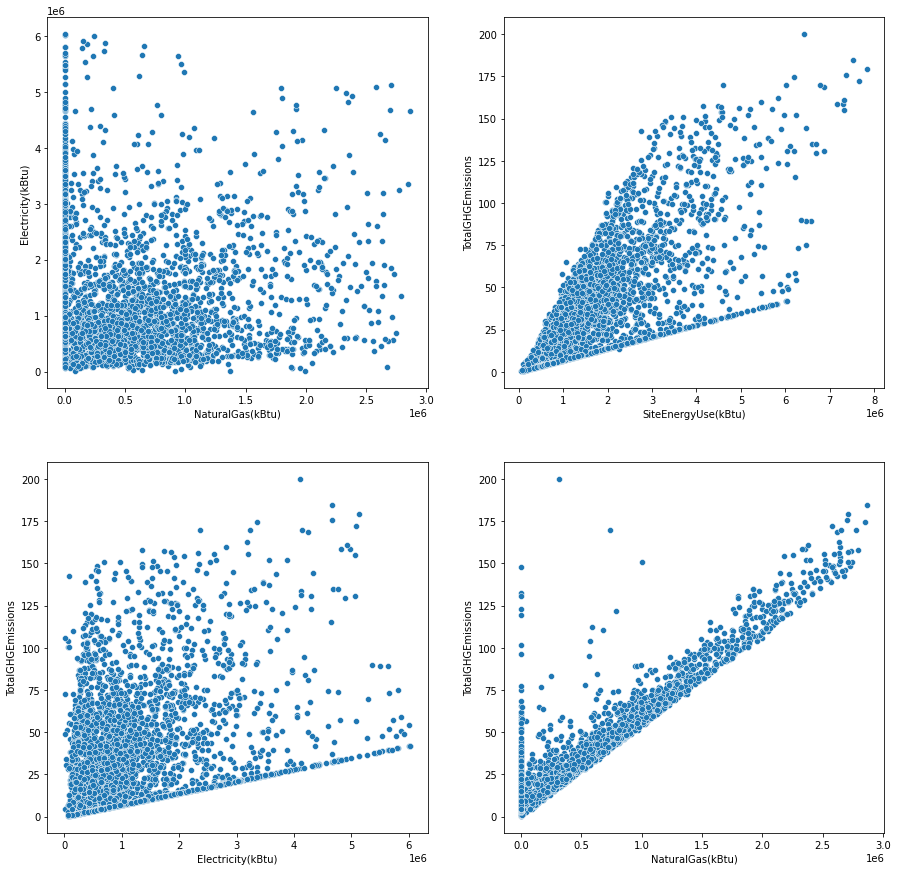

In [48]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(15,15))

sns.scatterplot(x='NaturalGas(kBtu)', y='Electricity(kBtu)', data=df ,ax=ax[0,0])
sns.scatterplot(x='SiteEnergyUse(kBtu)', y='TotalGHGEmissions', data=df, ax=ax[0,1])
sns.scatterplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=df, ax=ax[1,0])
sns.scatterplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=df, ax=ax[1,1])

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='LargestPropertyUseType'>

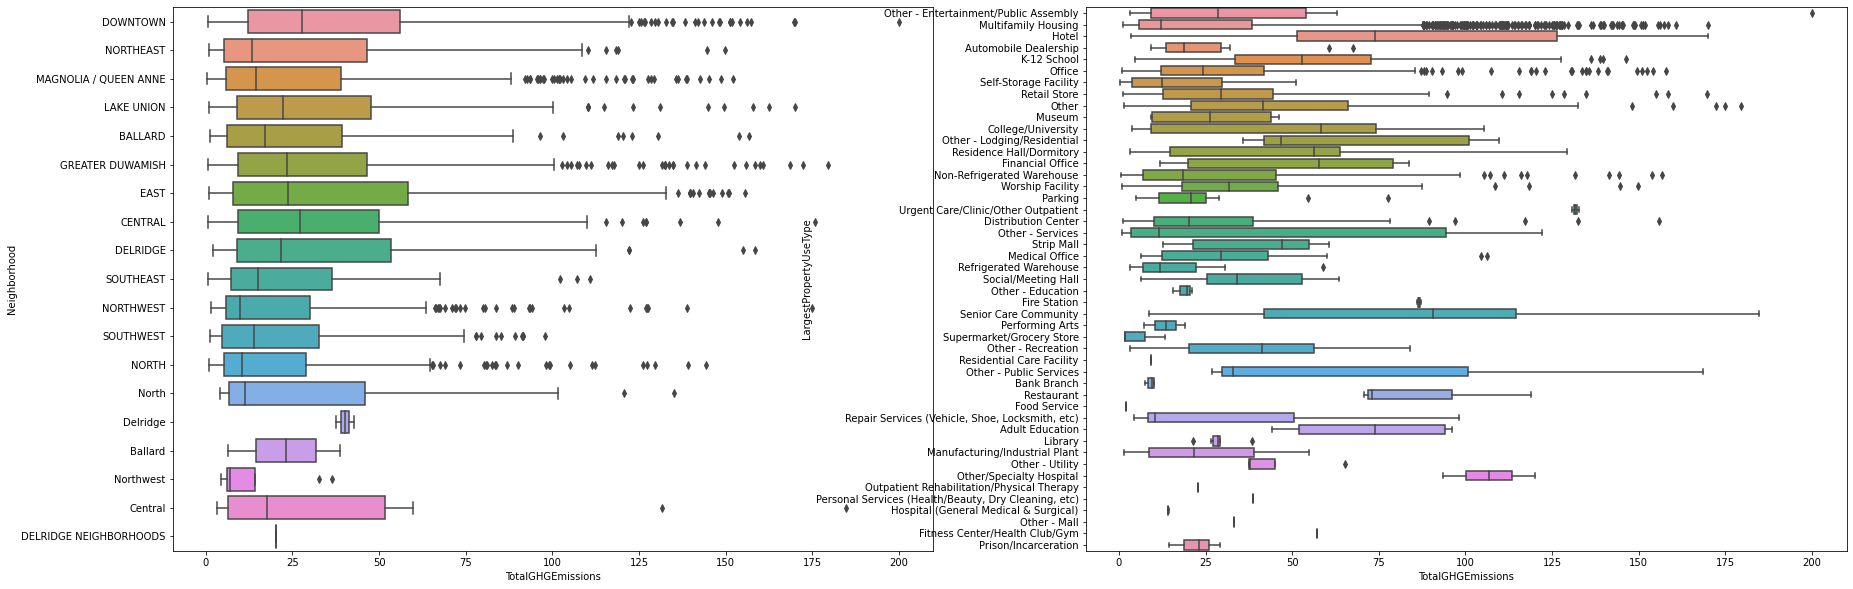

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.boxplot(x='TotalGHGEmissions', y='Neighborhood', data=df, ax=ax[0])
sns.boxplot(x='TotalGHGEmissions', y='LargestPropertyUseType', data=df, ax=ax[1])

(2,)


<AxesSubplot:xlabel='Distance', ylabel='SiteEnergyUse(kBtu)'>

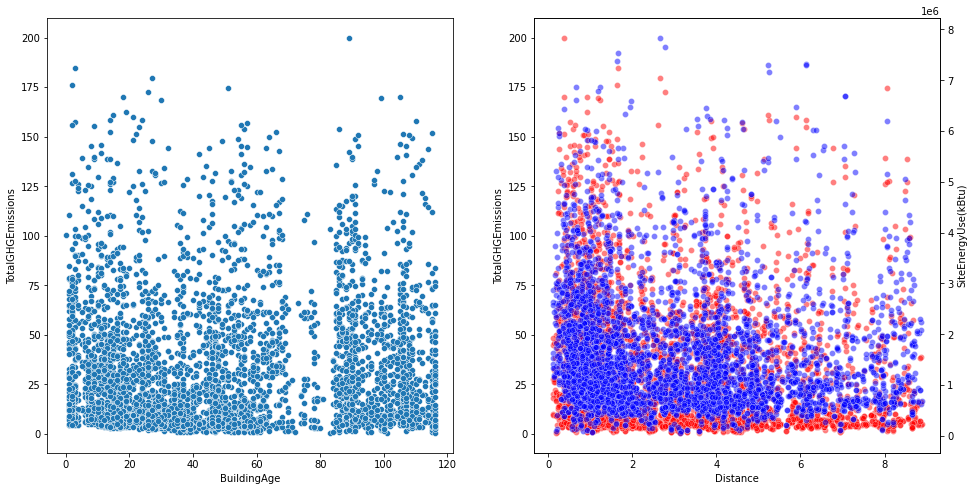

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(16,8))
print(ax.shape)
# plt.figure(figsize=(8,8))

sns.scatterplot(y='TotalGHGEmissions', x='BuildingAge', data=df, ax=ax[0])

ax1 = ax[1]
ax2 = ax1.twinx()
sns.scatterplot(y='TotalGHGEmissions', x='Distance', data=df, ax=ax1, color='red', alpha=0.5)
sns.scatterplot(y='SiteEnergyUse(kBtu)', x='Distance', data=df, ax=ax2, color='blue', alpha=0.5)